In [12]:
from abc import ABC, abstractmethod
import math

def paren_if_instance(exp,*args):
    for typ in args:
        if isinstance(exp,typ):
            return "\\left( {} \\right)".format(exp.latex())
    return exp.latex()

def package(maybe_expression):
    if isinstance(maybe_expression,Expression):
        return maybe_expression
    elif isinstance(maybe_expression,int) or isinstance(maybe_expression,float):
        return Number(maybe_expression)
    else:
        raise ValueError("can't convert {} to expression.".format(maybe_expression))
def dot_if_necessary(latex):
    if latex[0] in '-1234567890':
        return '\\cdot {}'.format(latex)
    else:
        return latex
        
class Expression(ABC):
    @abstractmethod
    def latex(self):
        pass
    def _repr_latex_(self):
        return "$$" + self.latex() + "$$"
    @abstractmethod
    def evaluate(self, **bindings):
        pass
    @abstractmethod
    def substitute(self, var, expression):
        pass
    @abstractmethod
    def expand(self):
        pass
    @abstractmethod
    def display(self):
        pass
    def __repr__(self):
        return self.display()
    @abstractmethod
    def derivative(self,var):
        pass
    
    def __call__(self, *inputs):
        var_list = sorted(distinct_variables(self))
        return self.evaluate(**dict(zip(var_list, inputs)))
    
    def __add__(self, other):
        return Sum(self,package(other))
    
    def __sub__(self,other):
        return Difference(self,package(other))
    
    def __mul__(self,other):
        return Product(self,package(other))
    
    def __rmul__(self,other):
        return Product(package(other),self)
    
    def __truediv__(self,other):
        return Quotient(self,package(other))
    
    def __pow__(self,other):
        return Power(self,package(other))
    
    @abstractmethod
    def _python_expr(self):
        pass
    
    def python_function(self,**bindings):
#         code = "lambda {}:{}".format(
#             ", ".join(sorted(distinct_variables(self))),
#             self._python_expr())
#         print(code)
        global_vars = {"math":math}
        return eval(self._python_expr(),global_vars,bindings)

class Sum(Expression):
    def __init__(self, *exps):
        self.exps = exps
    def latex(self):
        return " + ".join(exp.latex() for exp in self.exps)
    def evaluate(self, **bindings):
        return sum([exp.evaluate(**bindings) for exp in self.exps])
    def expand(self):
        return Sum(*[exp.expand() for exp in self.exps])
    def display(self):
        return "Sum({})".format(",".join([e.display() for e in self.exps]))
    def derivative(self, var):
        return Sum(*[exp.derivative(var) for exp in self.exps])
    def substitute(self, var, new):
        return Sum(*[exp.substitute(var,new) for exp in self.exps])
    def _python_expr(self):
        return "+".join("({})".format(exp._python_expr()) for exp in self.exps)
    
class Product(Expression):
    def __init__(self, exp1, exp2):
        self.exp1 = exp1
        self.exp2 = exp2
    def latex(self):
        return "{}{}".format(
            paren_if_instance(self.exp1,Sum,Negative,Difference),
            dot_if_necessary(paren_if_instance(self.exp2,Sum,Negative,Difference)))
    def evaluate(self, **bindings):
        return self.exp1.evaluate(**bindings) * self.exp2.evaluate(**bindings)
    def expand(self):
        expanded1 = self.exp1.expand()
        expanded2 = self.exp2.expand()
        if isinstance(expanded1, Sum):
            return Sum(*[Product(e,expanded2).expand() for e in expanded1.exps])
        elif isinstance(expanded2, Sum):
            return Sum(*[Product(expanded1,e) for e in expanded2.exps])
        else:
            return Product(expanded1,expanded2)
        
    def display(self):
        return "Product({},{})".format(self.exp1.display(),self.exp2.display())
    
    def derivative(self,var):
        if not contains(self.exp1, var):
            return Product(self.exp1, self.exp2.derivative(var))
        elif not contains(self.exp2, var):
            return Product(self.exp1.derivative(var), self.exp2)
        else:
            return Sum(
                Product(self.exp1.derivative(var), self.exp2),
                Product(self.exp1, self.exp2.derivative(var)))

    def substitute(self, var, exp):
        return Product(self.exp1.substitute(var,exp), self.exp2.substitute(var,exp))
    
    def _python_expr(self):
        return "({})*({})".format(self.exp1._python_expr(), self.exp2._python_expr())
    
class Difference(Expression):
    def __init__(self,exp1,exp2):
        self.exp1 = exp1
        self.exp2 = exp2
    def latex(self):
        return "{} - {}".format(
            self.exp1.latex(),
            paren_if_instance(self.exp2,Sum,Difference,Negative))
    def evaluate(self, **bindings):
        return self.exp1.evaluate(**bindings) - self.exp2.evaluate(**bindings)
    def expand(self):
        return self
    def display(self):
        return "Difference({},{})".format(self.exp1.display(), self.exp2.display())
    def derivative(self,var):
        return Difference(self.exp1.derivative(var),self.exp2.derivative(var))
    def substitute(self, var, exp):
        return Difference(self.exp1.substitute(var,exp), self.exp2.substitute(var,exp))   
    def _python_expr(self):
        return "({}) - ({})".format(self.exp1._python_expr(), self.exp2._python_expr())
    
class Quotient(Expression):
    def __init__(self,numerator,denominator):
        self.numerator = numerator
        self.denominator = denominator
    def latex(self):
        return "\\frac{{ {} }}{{ {} }}".format(self.numerator.latex(),self.denominator.latex())
    def evaluate(self, **bindings):
        return self.numerator.evaluate(**bindings) / self.denominator.evaluate(**bindings)
    def expand(self):
        return self
    def display(self):
        return "Quotient({},{})".format(self.numerator.display(),self.denominator.display())
    def substitute(self, var, exp):
        return Quotient(self.numerator.substitute(var,exp), self.denominator.substitute(var,exp))
    def derivative(self, var):
        return Quotient(
            Difference(
                Product(self.denominator, self.numerator.derivative(var)),
                Product(self.numerator, self.denominator.derivative(var))
            ),
            Power(self.denominator,Number(2)))
    def _python_expr(self):
        return "({}) / ({})".format(self.exp1._python_expr(), self.exp2._python_expr())
    
class Negative(Expression):
    def __init__(self,exp):
        self.exp = exp
    def latex(self):
        return "- {}".format(
            paren_if_instance(self.exp,Sum,Difference,Negative))
    def evaluate(self, **bindings):
        return - self.exp.evaluate(**bindings)
    def expand(self):
        return self
    def derivative(self,var):
        return Negative(self.exp.derivative(var))
    def substitute(self,var,exp):
        return Negative(self.exp.substitute(var,exp))
    def _python_expr(self):
        return "- ({})".format(self.exp._python_expr())
    def display(self):
        return "Negative({})".format(self.exp.display())
    
class Number(Expression):
    def __init__(self,number):
        self.number = number
    def latex(self):
        return str(self.number)
    def evaluate(self, **bindings):
        return self.number
    def expand(self):
        return self
    def display(self):
        return "Number({})".format(self.number)
    def derivative(self,var):
        return Number(0)
    def substitute(self,var,exp):
        return self
    def _python_expr(self):
        return str(self.number)
    
class Power(Expression):
    def __init__(self,base,exponent):
        self.base = base
        self.exponent = exponent
    def latex(self):
        return "{} ^ {{ {} }}".format(
            paren_if_instance(self.base, Sum, Negative, Difference, Quotient, Product),
            self.exponent.latex())
    def evaluate(self, **bindings):
        return self.base.evaluate(**bindings) ** self.exponent.evaluate(**bindings)
    def expand(self):
        return self
#         expanded_exponent = self.exponent.expand()
#         print (expanded_exponent)
#         if isinstance(expanded_exponent, Number)\
#             and (expanded_exponent.number % 1 == 0)\
#             and (expanded_exponent.number > 0):
#                 power = int(expanded_exponent.number)
#                 if power == 1:
#                     return self.base.expand()
#                 else:
#                     return Product(self.base.expand(), Power(self.base,Number(power-1)).expand()).expand()
#         else:
#             return Power(self.base.expand, expanded_exponent)
    def display(self):
        return "Power({},{})".format(self.base.display(),self.exponent.display())
    def derivative(self,var):
        if isinstance(self.exponent, Number):
            power_rule = Product(
                    Number(self.exponent.number), 
                    Power(self.base, Number(self.exponent.number - 1)))
            return Product(self.base.derivative(var),power_rule)
        elif isinstance(self.base, Number):
            exponential_rule = Product(Apply(Function("ln"),Number(self.base.number)), self)
            return Product(self.exponent.derivative(var), exponential_rule)
        else:
            raise Exception("couldn't take derivative of power {}".format(self.display()))
    def substitute(self,var,exp):
        return Power(self.base.substitute(var,exp), self.exponent.substitute(var,exp))
    
    def _python_expr(self):
        return "({}) ** ({})".format(self.base._python_expr(), self.exponent._python_expr())
    
class Variable(Expression):
    def __init__(self,symbol):
        self.symbol = symbol
    def latex(self):
        return self.symbol
    def evaluate(self, **bindings):
        return bindings[self.symbol]
    def expand(self):
        return self
    def display(self):
        return "Variable(\"{}\")".format(self.symbol)
    def derivative(self, var):
        if self.symbol == var.symbol:
            return Number(1)
        else:
            return Number(0)
    def substitute(self, var, exp):
        if self.symbol == var.symbol:
            return exp
        else:
            return self
        
    def _python_expr(self):
        return self.symbol
        
class Function():
    def __init__(self,name,make_latex=None):
        self.name = name
        self.make_latex = make_latex
    def latex(self,arg_latex):
        if self.make_latex:
            return self.make_latex(arg_latex)
        else:
            return " \\operatorname{{ {} }} \\left( {} \\right)".format(self.name, arg_latex)
  
class Apply(Expression):
    def __init__(self,function,argument):
        self.function = function
        self.argument = argument
    def latex(self):
        return self.function.latex(self.argument.latex())
#         return "\\operatorname{{ {} }} \\left( {} \\right)".format(self.function.name, self.argument.latex())
    def evaluate(self, **bindings):
        return _function_bindings[self.function.name](self.argument.evaluate(**bindings))
    def expand(self):
        return Apply(self.function, self.argument.expand())
    def display(self):
        return "Apply(Function(\"{}\"),{})".format(self.function.name, self.argument.display())
    def derivative(self, var):
        return Product(
                self.argument.derivative(var), 
                _derivatives[self.function.name].substitute(_var, self.argument))
    def substitute(self,var,exp):
        return Apply(self.function, self.argument.substitute(var,exp))
    
    def _python_expr(self):
        return _function_python[self.function.name].format(self.argument._python_expr())

_function_bindings = {
    "sin": math.sin,
    "cos": math.cos,
    "ln": math.log,
    "sqrt": math.sqrt
}

_function_python = {
    "sin": "math.sin({})",
    "cos": "math.cos({})",
    "ln": "math.log({})",
    "sqrt": "math.sqrt({})"
}

_var = Variable('placeholder variable')

_derivatives = {
    "sin": Apply(Function("cos"), _var),
    "cos": Product(Number(-1), Apply(Function("sin"), _var)),
    "ln": Quotient(Number(1), _var),
    "sqrt": Quotient(Number(1), Product(Number(2), Apply(Function("sqrt"), _var)))
}
    
x = Variable('x')
y = Variable('y')
z = Variable('z')
a = Variable('a')
b = Variable('b')

def _apply(func_name):
    return (lambda x: Apply(Function(func_name), x))

Sin = _apply("sin")
Cos = _apply("cos")
Sqrt = lambda exp: Apply(Function('sqrt', lambda s: "\\sqrt{{ {} }}".format(s)), exp)

# TODO: equality
# TODO: evalb
# TODO: substitution
# TODO: derivative

In [13]:
def distinct_variables(exp):
    if isinstance(exp, Variable):
        return set(exp.symbol)
    elif isinstance(exp, Number):
        return set()
    elif isinstance(exp, Sum):
        return set().union(*[distinct_variables(exp) for exp in exp.exps])
    elif isinstance(exp, Product):
        return distinct_variables(exp.exp1).union(distinct_variables(exp.exp2))
    elif isinstance(exp, Power):
        return distinct_variables(exp.base).union(distinct_variables(exp.exponent))
    elif isinstance(exp, Apply):
        return distinct_variables(exp.argument)
    else:
        raise TypeError("Not a valid expression.")
    

In [19]:
def contains(exp, var):
    if isinstance(exp, Variable):
        return exp.symbol == var.symbol
    elif isinstance(exp, Number):
        return False
    elif isinstance(exp, Sum):
        return any([contains(e,var) for e in exp.exps])
    elif isinstance(exp, Product):
        return contains(exp.exp1,var) or contains(exp.exp2,var)
    elif isinstance(exp, Power):
        return contains(exp.base, var) or contains(exp.exponent, var)
    elif isinstance(exp, Apply):
        return contains(exp.argument, var)
    else:
        raise TypeError("Not a valid expression.")

In [15]:
(6*Cos(x**2))._python_expr()

'(6)*(math.cos((x) ** (2)))'

In [16]:
(6*Cos(x**2)).python_function(x=0)

6.0

In [17]:
(6*Cos(x**2)).evaluate(x=0)

6.0

In [18]:
(x**2)(3)

9

In [85]:
Sqrt(x).derivative(x)

Product(Number(1),Quotient(Number(1),Product(Number(2),Apply(Function("sqrt"),Variable("x")))))

In [86]:
isinstance(x**y,Expression)

True

In [87]:
(a+b)*(x+y)
# Power(Sum(X,Y),Number(3)).expand()

Product(Sum(Variable("a"),Variable("b")),Sum(Variable("x"),Variable("y")))

In [88]:
Sqrt(x)

Apply(Function("sqrt"),Variable("x"))

In [89]:
A = Variable('a')
B = Variable('b')
C = Variable('c')
Sqrt = Function('sqrt')
Sqrt = Function('sqrt', lambda s: "\\sqrt{{ {} }}".format(s))

Quotient(Sum(Negative(B),Apply(Sqrt, Difference(Power(B,Number(2)),Product(Number(4), Product(A,C))))),Product(Number(2), A))

Quotient(Sum(Negative(Variable("b")),Apply(Function("sqrt"),Difference(Power(Variable("b"),Number(2)),Product(Number(4),Product(Variable("a"),Variable("c")))))),Product(Number(2),Variable("a")))

In [90]:
Difference(Power(Variable('b'),Number(2)),Product(Number(4),Product(Variable('a'), Variable('c'))))

Difference(Power(Variable("b"),Number(2)),Product(Number(4),Product(Variable("a"),Variable("c"))))

In [91]:
Negative(Sum(Power(Variable("x"),Number(2)),Variable("y")))

Negative(Sum(Power(Variable("x"),Number(2)),Variable("y")))

In [92]:
Apply(Function("ln"), Power(Variable("y"), Variable("z")))

Apply(Function("ln"),Power(Variable("y"),Variable("z")))

In [93]:
Product(Number(3),Sum(Variable("y"),Variable("z")))

Product(Number(3),Sum(Variable("y"),Variable("z")))

In [94]:
(x-y)**3

Power(Difference(Variable("x"),Variable("y")),Number(3))

In [95]:
from math import log
def f(y,z):
    return log(y**z)
Quotient(Sum(Variable("a"),Variable("b")),Number(2))

Quotient(Sum(Variable("a"),Variable("b")),Number(2))

In [96]:
(a+b)*(x+y)

Product(Sum(Variable("a"),Variable("b")),Sum(Variable("x"),Variable("y")))

In [97]:
Sin(x*(y+z))

Apply(Function("sin"),Product(Variable("x"),Sum(Variable("y"),Variable("z"))))

In [98]:
X=x
Y=y
Z=z
Apply(Function('sin'),Product(X,Sum(Y,Z))).expand()

Apply(Function("sin"),Sum(Product(Variable("x"),Variable("y")),Product(Variable("x"),Variable("z"))))

In [99]:
f_expression = Product(
                Sum(
                    Product(
                        Number(3),
                        Power(
                            Variable("x"),
                            Number(2))), 
                    Variable("x")), 
                Apply(
                    Function("sin"),
                    Variable("x")))

In [100]:
f_expression

Product(Sum(Product(Number(3),Power(Variable("x"),Number(2))),Variable("x")),Apply(Function("sin"),Variable("x")))

In [41]:
f_expression.expand().display()

'Sum(Product(Product(Number(3),Power(Variable("x"),Number(2))),Apply(Function("sin"),Variable("x"))),Product(Variable("x"),Apply(Function("sin"),Variable("x"))))'

In [42]:
str(f_expression.expand())

'Sum(Product(Product(Number(3),Power(Variable("x"),Number(2))),Apply(Function("sin"),Variable("x"))),Product(Variable("x"),Apply(Function("sin"),Variable("x"))))'

In [43]:
Sum(Y,Z).exps

(Variable("y"), Variable("z"))

In [44]:
x = Variable("x")
y = Variable("y")
Power(Product(Quotient(x,Number(3/2)),y),Apply(Function("sin"),Sum(x,x,x,x)))

Power(Product(Quotient(Variable("x"),Number(1.5)),Variable("y")),Apply(Function("sin"),Sum(Variable("x"),Variable("x"),Variable("x"),Variable("x"))))

In [45]:
Power(x,y).evaluate(x=3,y=2)

9

In [46]:
Apply(Function("cos"), Number(math.pi/4)).evaluate()

0.7071067811865476

In [47]:
dict({"e":3},**{"e":4,"f":5})

{'e': 4, 'f': 5}

In [48]:
from math import sin
def f(x):
    return (3*x + 1) * sin(x)

In [49]:
import inspect
def contains_sin(f):
    source = inspect.getsource(f)
    return 'sin' in source

In [50]:
contains_sin(f)

True

In [51]:
foo = sin
def g(x):
    return foo(x)
def h(x):
    preprocessing = x + 3
    return preprocessing

In [52]:
contains_sin(g)

False

In [53]:
contains_sin(h)

True

In [54]:
Power(Variable("x"),Number(2))

Power(Variable("x"),Number(2))

In [55]:
Product(Number(3),Power(Variable("x"),Number(2)))

Product(Number(3),Power(Variable("x"),Number(2)))

In [56]:
f_expression

Product(Sum(Product(Number(3),Power(Variable("x"),Number(2))),Variable("x")),Apply(Function("sin"),Variable("x")))

In [57]:
Apply(Function("cos"),Sum(Power(Variable("x"),Number("3")), Number(-5)))

Apply(Function("cos"),Sum(Power(Variable("x"),Number(3)),Number(-5)))

In [59]:
test = Sum(Variable("x"),Number(5),Product(Variable("y"),Power(Variable('z'),Apply(Function('sin'),Variable('p')))))
test

Sum(Variable("x"),Number(5),Product(Variable("y"),Power(Variable("z"),Apply(Function("sin"),Variable("p")))))

In [60]:
distinct_variables(test)

{'p', 'x', 'y', 'z'}

In [61]:
[1,2,3] + [4,5]

[1, 2, 3, 4, 5]

In [62]:
{3,4,5} | {5,6,7}

{3, 4, 5, 6, 7}

In [63]:
set().union(*({x} for x in range(0,10)))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [64]:
distinct_variables(Variable("z"))

{'z'}

In [65]:
distinct_variables(Number(3))

set()

In [66]:
distinct_variables(f_expression)

{'x'}

In [67]:
Sum(Number(3),Number(3)) is Sum

False

In [68]:
X = Variable('x')
Y = Variable('y')
Z = Variable('z')
Product(X,Sum(Y,Z)).expand()

Sum(Product(Variable("x"),Variable("y")),Product(Variable("x"),Variable("z")))

In [69]:
5.0 % 1

0.0

In [102]:
import matplotlib.pyplot as plt
import numpy as np

def secant(y,xmin,xmax):
    slope = (y(xmax) - y(xmin)) / (xmax - xmin)
    def linear_function(x):
        return slope * (x - xmin) + y(xmin)
    return linear_function
def secant_slope(f,xmin,xmax):
    return (f(xmax) - f(xmin)) / (xmax - xmin)

def plot_function(f,xmin,xmax,color=None):
    ts = np.linspace(xmin,xmax,1000)
    plt.plot(ts,[f(t) for t in ts],c=color)
    
def plot_secant(y,xmin,xmax,color=None,points=False):
    plot_function(secant(y,xmin,xmax),xmin,xmax,color=color)
    if points:
        plt.scatter([xmin,xmax],[y(xmin),y(xmax)],c=color)

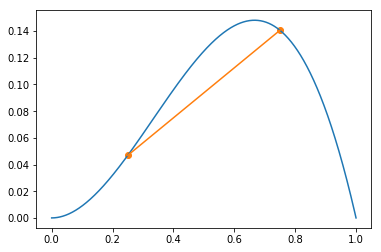

In [103]:
y = lambda x: x**2-x**3
plot_function(y, 0, 1)
plot_secant(y,0.25,0.75,points=True,color='C1')


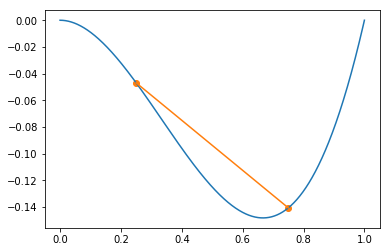

In [104]:
plot_function(lambda x: -y(x), 0, 1)
plot_secant(lambda x: -y(x),0.25,0.75,points=True,color='C1')

(-0.1, 0.8)

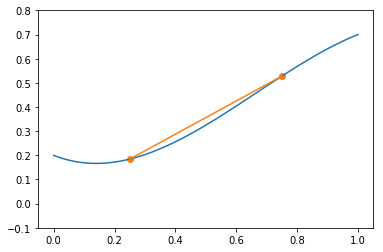

In [105]:
from math import sin

def z(x):
    return 0.2 - 0.5*x + x**2

# plot_function(y, 0, 1)
# plot_secant(y,0.25,0.75,points=True,color='C1')

# plot_function(z, 0, 1, color='C0')
# plot_secant(z,0.25,0.75,points=True,color='C1')

plot_function(lambda x: y(x)+z(x), 0, 1, color='C0')
plot_secant(lambda x: y(x)+z(x),0.25,0.75,points=True,color='C1')

plt.ylim(-0.1,0.8)

In [106]:
Product(Number(2),X).derivative(X)

Product(Number(2),Number(1))

In [107]:
Power(X,Number(2)).derivative(X).derivative(X).derivative(X).derivative(X)

Product(Number(1),Product(Number(2),Product(Number(1),Product(Number(1),Product(Number(1),Product(Number(0),Product(Number(1),Product(Number(-1),Power(Variable("x"),Number(-2))))))))))

In [108]:
Product(X,Y).derivative(Y)

Product(Variable("x"),Number(1))

In [109]:
math.log

<function math.log>

In [110]:
Power(X,Number(2)).derivative(X)

Product(Number(1),Product(Number(2),Power(Variable("x"),Number(1))))

In [111]:
_ = "_"

In [112]:
_ = Variable("\\_")
_

Variable("\_")

In [113]:
Apply(Function("sin"),X).derivative(X)

Product(Number(1),Apply(Function("cos"),Variable("x")))

In [114]:
Power(X,Number(2)).substitute(X, Sum(Y,Z))

Power(Sum(Variable("y"),Variable("z")),Number(2))

In [115]:
Power(Apply(Function("sin"),X),Number(13.5)).derivative(X)

Product(Product(Number(1),Apply(Function("cos"),Variable("x"))),Product(Number(13.5),Power(Apply(Function("sin"),Variable("x")),Number(12.5))))

In [116]:
Power(Number(2),Apply(Function("sin"),X)).derivative(X)

Product(Product(Number(1),Apply(Function("cos"),Variable("x"))),Product(Apply(Function("ln"),Number(2)),Power(Number(2),Apply(Function("sin"),Variable("x")))))

In [117]:
Apply(Function("ln"),Apply(Function("cos"), X)).derivative(X)

Product(Product(Number(1),Product(Number(-1),Apply(Function("sin"),Variable("x")))),Quotient(Number(1),Apply(Function("cos"),Variable("x"))))

In [118]:
Quotient(Apply(Function("sin"),X),Apply(Function("cos"),X)).derivative(X)

Quotient(Difference(Product(Apply(Function("cos"),Variable("x")),Product(Number(1),Apply(Function("cos"),Variable("x")))),Product(Apply(Function("sin"),Variable("x")),Product(Number(1),Product(Number(-1),Apply(Function("sin"),Variable("x")))))),Power(Apply(Function("cos"),Variable("x")),Number(2)))

In [119]:
Sum(Variable("x"),Variable("c"),Number(1)).derivative(Variable("x")).display()

'Sum(Number(1),Number(0),Number(0))'

In [120]:
Power(Sum(X,Number(1)),Number(4)).derivative(X)

Product(Sum(Number(1),Number(0)),Product(Number(4),Power(Sum(Variable("x"),Number(1)),Number(3))))

In [121]:
Product(Variable("c"),Variable("x")).derivative(Variable("x")).display()

'Product(Variable("c"),Number(1))'

In [122]:
Apply(Function("sin"),Power(Variable("x"),Number(2))).derivative(X)

Product(Product(Number(1),Product(Number(2),Power(Variable("x"),Number(1)))),Apply(Function("cos"),Power(Variable("x"),Number(2))))

In [123]:
f_expression.derivative(X)

Sum(Product(Sum(Product(Number(3),Product(Number(1),Product(Number(2),Power(Variable("x"),Number(1))))),Number(1)),Apply(Function("sin"),Variable("x"))),Product(Sum(Product(Number(3),Power(Variable("x"),Number(2))),Variable("x")),Product(Number(1),Apply(Function("cos"),Variable("x")))))

In [124]:
f_expression

Product(Sum(Product(Number(3),Power(Variable("x"),Number(2))),Variable("x")),Apply(Function("sin"),Variable("x")))

In [125]:
from sympy import *
from sympy.core.core import *

Mul(Symbol('y'),Add(3,Symbol('x')))

y*(x + 3)

In [126]:
y = Symbol('y')
x = Symbol('x')
y*(3+x)

y*(x + 3)

In [127]:
y*(3+x).subs(x,1)

4*y

In [128]:
(x**2).diff(x)

2*x

In [129]:
integrate(tan(x))

-log(sin(x)**2 - 1)/2

In [130]:
(3*x**2).integrate(x)

x**3

In [131]:
t = Symbol('t')
(-9.81*t).integrate(t)

-4.905*t**2

In [132]:
integrate(tan(x),x)

-log(sin(x)**2 - 1)/2

In [133]:
x = Symbol('x')
type(3+x)

sympy.core.add.Add

In [134]:
import sympy
from sympy.core.core import *

In [135]:
Add

sympy.core.add.Add

In [136]:
Add(3,x)

x + 3

In [137]:
Mul(2,Add(x,3))

2*x + 6

In [138]:
(x**2).integrate(x)

x**3/3

In [139]:
(x*cos(x)).integrate(x)

x*sin(x) + cos(x)

In [140]:
zero = (x - x)

In [141]:
zero.integrate(x)

0

In [142]:
sympy.core

<module 'sympy.core.core' from 'C:\\Users\\Paul\\Anaconda3\\lib\\site-packages\\sympy\\core\\core.py'>

In [143]:
type(x-x)

sympy.core.numbers.Zero

In [144]:
sympy.core.numbers.Zero

AttributeError: module 'sympy.core.core' has no attribute 'numbers'

In [145]:
Integer(0).integrate(x)

0

In [65]:
variables

NameError: name 'variables' is not defined

In [82]:
code = "lambda {}:{}".format(
    ", ".join(sorted(distinct_variables(3*x**y))),
    "3*x**y")
f = eval(code)

In [83]:
f(2,3)

24

In [140]:
def distinct_functions(exp):
    if isinstance(exp, Variable):
        return set()
    elif isinstance(exp, Number):
        return set()
    elif isinstance(exp, Sum):
        return set().union(*[distinct_functions(exp) for exp in exp.exps])
    elif isinstance(exp, Product):
        return distinct_functions(exp.exp1).union(distinct_functions(exp.exp2))
    elif isinstance(exp, Power):
        return distinct_functions(exp.base).union(distinct_functions(exp.exponent))
    elif isinstance(exp, Apply):
        return set([exp.function.name]).union(distinct_functions(exp.argument))
    else:
        raise TypeError("Not a valid expression.")

In [141]:
distinct_functions(Sin(x)*Cos(x))

{'cos', 'sin'}

In [143]:
Power(Variable("x"),Number(2))._python_expr()

'(x) ** (2)'

In [144]:
Power(Variable("x"),Number(2)).python_function(x=3)

9

In [145]:
def contains_sum(exp):
    if isinstance(exp, Variable):
        return False
    elif isinstance(exp, Number):
        return False
    elif isinstance(exp, Sum):
        return True
    elif isinstance(exp, Product):
        return contains_sum(exp.exp1) or contains_sum(exp.exp2)
    elif isinstance(exp, Power):
        return contains_sum(exp.base) or contains_sum(exp.exponent)
    elif isinstance(exp, Apply):
        return contains_sum(exp.argument)
    else:
        raise TypeError("Not a valid expression.")

In [146]:
contains_sum(x+y)

True

In [147]:
contains_sum(x**(y+z))

True

In [149]:
contains_sum(x*3*Cos(x))

False

In [151]:
Product(Power(Variable("x"),Number(2)),Apply(Function("sin"),Variable("y")))

Product(Power(Variable("x"),Number(2)),Apply(Function("sin"),Variable("y")))

In [174]:
def derivative_at_point(f,x,dx=1e-6):
    return secant_slope(f,x-dx,x+dx)

In [175]:
def derivative(f, dx=1e-6):
    return lambda x: derivative_at_point(f,x,dx=dx)

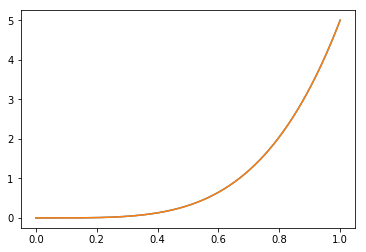

In [178]:
def p(x):
    return x**5
plot_function(derivative(p), 0, 1)
plot_function(lambda x: 5*x**4, 0, 1)

In [184]:
x = Variable("x")
y = Variable("y")
z = Variable("z")
"x" in distinct_variables(x+y**z)

True

In [198]:
contains(x+y**z, a)

False